<a href="https://colab.research.google.com/github/Kim-Yeonjoo/DeepLearning/blob/main/9_1_object_detecting_yolov3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 정지 영상에서 객체 탐지

## 필요한 라이브러리 import

In [1]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow # Google Colab에서 이미지를 표시하기 위한 함수

## YOLO(YOu Only Look Once) 모델 관련 파일 다운로드

In [2]:
# YOLO(YOu Only Look Once) 모델
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O yolov3.cfg
!wget https://github.com/pjreddie/darknet/blob/master/data/coco.names?raw=true -O coco.names

--2025-01-17 05:32:08--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  36.7MB/s    in 6.8s    

2025-01-17 05:32:15 (34.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2025-01-17 05:32:16--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/refs/heads/master/cfg/yolov3.cfg [following]
--2025-01-17 05:32:16--  https://github.com/pjreddie/darknet/raw/refs/heads/master/cfg/yolov3.cfg
Reusing existing connection to github.com:443.
HTT

## YOLO 모델 초기화 및 로드 함수

In [3]:
def load_yolo():
    net = cv.dnn.readNet("yolov3.weights", "yolov3.cfg")
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    layers_names = net.getLayerNames()
    output_layers = [layers_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]
    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    return net, classes, colors, output_layers

## 이미지 로드 및 전처리 함수

In [4]:
def load_image(img_path):
    img = cv.imread(img_path)
    img = cv.resize(img, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape
    return img, height, width, channels

## 객체 탐지 함수

In [5]:
def detect_objects(img, net, outputLayers):
    blob = cv.dnn.blobFromImage(img, scalefactor=0.00392, size=(416, 416), mean=(0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(outputLayers)
    return blob, outputs


## 탐지된 객체 정보


YOLO 네트워크의 출력에서 객체의 위치와 해당 클래스의 신뢰도를 추출하여 리스트로 저장

YOLO 모델의 출력을 파싱하여 각 객체에 대한 경계 상자의 위치, 신뢰도 점수 및 클래스 ID를 추출합니다. 이 정보는 객체를 이미지 위에 표시하거나 추가 분석을 위해 사용

In [7]:
def get_box_dimensions(outputs, height, width):
    boxes = []
    confs = []
    class_ids = []

    for output in outputs:
        for detect in output:
            scores = detect[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5:                       # 감지 기준 설정
                center_x = int(detect[0] * width)
                center_y = int(detect[1] * height)
                w = int(detect[2] * width)             # 좌표
                h = int(detect[3] * height)

                # 경계선 그려주는 영역
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])             # 박스 이미지
                confs.append(float(confidence))        # 확률 값
                class_ids.append(class_id)

    return boxes, confs, class_ids


## NMS & 바운딩 박스 그리기 함수

In [8]:
def draw_labels(boxes, confs, colors, class_ids, classes, img):
    indexes = cv.dnn.NMSBoxes(boxes, confs, 0.5, 0.4)
    font = cv.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confs[i]
            color = colors[class_ids[i]]
            cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv.putText(img, f"{label} {confidence:.2f}", (x, y + 30), font, 1, color, 2)
    cv2_imshow(img)

## 객체 탐지 실행


구글 이미지 검색 > 마우스 우클릭 > 링크주소 복사 실행

In [9]:
import requests

# 이미지 URL
image_url = "https://images.squarespace-cdn.com/content/v1/56690c0ca128e6e00f021af6/1461148473502-9D3SLDUVC7J87LTG63SL/BEAD+Al+Bateen+street2.JPG"

# 저장할 파일 이름
output_file = "street2.jpg"

# 이미지 다운로드 및 저장
response = requests.get(image_url, stream=True)
if response.status_code == 200:
    with open(output_file, "wb") as file:
        file.write(response.content)
    print(f"이미지가 {output_file}로 저장되었습니다!")
else:
    print(f"이미지를 다운로드할 수 없습니다. 상태 코드: {response.status_code}")


이미지가 street2.jpg로 저장되었습니다!


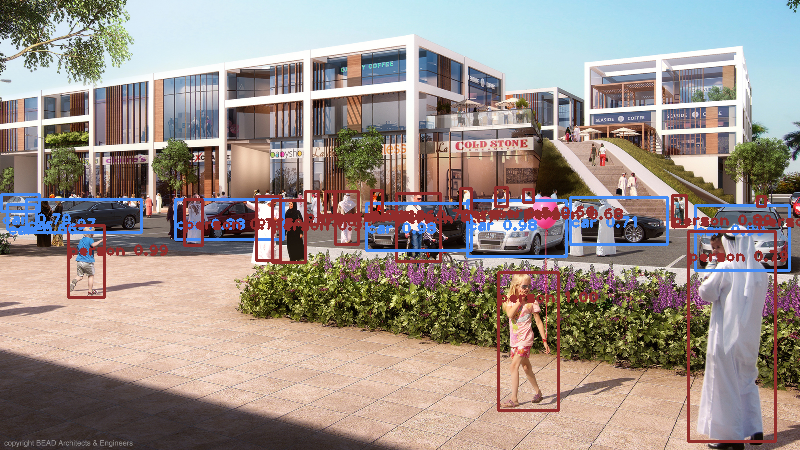

In [10]:
net, classes, colors, output_layers = load_yolo()             # 모델 올리기

image, height, width, channels = load_image("street2.jpg")   # 이미지 올리기

blob, outputs = detect_objects(image, net, output_layers)      # 감지

boxes, confs, class_ids = get_box_dimensions(outputs, height, width)    # 박스

draw_labels(boxes, confs, colors, class_ids, classes, image)    # 라벨


In [11]:
import requests

# 이미지 URL
image_url = "https://balijayu.com/wp-content/uploads/balisafari14-1.jpg"

# 저장할 파일 이름
output_file = "safari.jpg"

# 이미지 다운로드 및 저장
response = requests.get(image_url, stream=True)
if response.status_code == 200:
    with open(output_file, "wb") as file:
        file.write(response.content)
    print(f"이미지가 {output_file}로 저장되었습니다!")
else:
    print(f"이미지를 다운로드할 수 없습니다. 상태 코드: {response.status_code}")

이미지가 safari.jpg로 저장되었습니다!


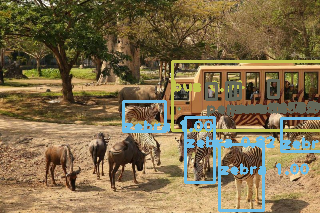

In [13]:
net, classes, colors, output_layers = load_yolo()             # 모델 올리기

image, height, width, channels = load_image("safari.jpg")   # 이미지 올리기

blob, outputs = detect_objects(image, net, output_layers)      # 감지

boxes, confs, class_ids = get_box_dimensions(outputs, height, width)    # 박스

draw_labels(boxes, confs, colors, class_ids, classes, image)    # 라벨

In [14]:
import requests

# 이미지 URL
image_url = "https://img.freepik.com/premium-photo/painting-safari-with-giraffes-giraffes-background_950347-3644.jpg?w=1060"

# 저장할 파일 이름
output_file = "safari2.jpg"

# 이미지 다운로드 및 저장
response = requests.get(image_url, stream=True)
if response.status_code == 200:
    with open(output_file, "wb") as file:
        file.write(response.content)
    print(f"이미지가 {output_file}로 저장되었습니다!")
else:
    print(f"이미지를 다운로드할 수 없습니다. 상태 코드: {response.status_code}")

이미지가 safari2.jpg로 저장되었습니다!


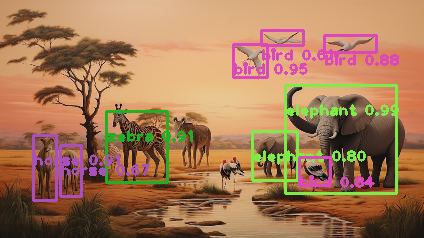

In [15]:
net, classes, colors, output_layers = load_yolo()             # 모델 올리기

image, height, width, channels = load_image("safari2.jpg")   # 이미지 올리기

blob, outputs = detect_objects(image, net, output_layers)      # 감지

boxes, confs, class_ids = get_box_dimensions(outputs, height, width)    # 박스

draw_labels(boxes, confs, colors, class_ids, classes, image)    # 라벨

In [16]:
import requests

# 이미지 URL
image_url = "https://img.hankyung.com/photo/202308/01.34322344.1.jpg"

# 저장할 파일 이름
output_file = "buildings.jpg"

# 이미지 다운로드 및 저장
response = requests.get(image_url, stream=True)
if response.status_code == 200:
    with open(output_file, "wb") as file:
        file.write(response.content)
    print(f"이미지가 {output_file}로 저장되었습니다!")
else:
    print(f"이미지를 다운로드할 수 없습니다. 상태 코드: {response.status_code}")

이미지가 buildings.jpg로 저장되었습니다!


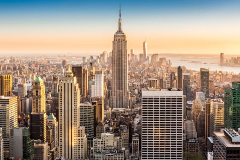

In [17]:
net, classes, colors, output_layers = load_yolo()             # 모델 올리기

image, height, width, channels = load_image("buildings.jpg")   # 이미지 올리기

blob, outputs = detect_objects(image, net, output_layers)      # 감지

boxes, confs, class_ids = get_box_dimensions(outputs, height, width)    # 박스

draw_labels(boxes, confs, colors, class_ids, classes, image)    # 라벨